# Calculating $\Sigma_{10}$


In the context of the paper "[The Sloan Lens ACS Survey. VIII. The Relation between Environment and Internal Structure of Early-Type Galaxies](https://arxiv.org/pdf/0806.1056.pdf)," the projected number density of galaxies inside the tenth nearest neighbor ($\Sigma_{10}$) refers to a measure of the local galaxy density surrounding a target early-type galaxy.

To explain this concept from the paper, we need to understand how the authors calculated $\Sigma_{10}$ and its significance in studying the relationship between galaxy environment and the internal structure of early-type galaxies.

1. Calculation of $\Sigma_{10}$:
In the paper, the authors studied a sample of early-type galaxies with measured gravitational lensing effects. For each target early-type galaxy, they identified its ten nearest neighbor galaxies based on their projected angular distances. The projected angular distance is the angular separation between the target galaxy and its neighbors as seen from our perspective on Earth.

$\Sigma_{10}$ is then calculated as the number of galaxies (including the target galaxy itself) within the combined area covered by the ten nearest neighbors, divided by the total area of that region. In other words, $\Sigma_{10}$ represents the number density of galaxies in the vicinity of the target galaxy, considering the influence of its ten closest neighbors.

2. Significance of $\Sigma_{10}$:
The projected number density $\Sigma_{10}$ is a crucial parameter to study the local galaxy environment around each early-type galaxy in the sample. It provides a measure of the galaxy density on small scales, capturing the immediate gravitational influences of nearby galaxies on the target galaxy.

By analyzing the correlation between $\Sigma_{10}$ and the internal properties of early-type galaxies (such as their effective radii and velocity dispersions), the authors can explore how the local galaxy environment affects the structure and evolution of early-type galaxies. High $\Sigma_{10}$ values imply dense environments with strong gravitational interactions, which might have implications for the growth and assembly history of the early-type galaxies.

In summary, $\Sigma_{10}$ quantifies the local galaxy density surrounding each target early-type galaxy in the sample. It plays a crucial role in understanding the impact of the immediate environment on the internal properties and evolution of these galaxies, providing insights into the complex interplay between galaxy environment and galaxy structure.

Finally calculations can be made by
$$\Sigma_{10} = 10/(\pi R_{10}^2)$$

## Issue for task

https://github.com/ajshajib/BDLensing/issues/191

We've to reproduce **figure no 4** of the SLACS paper for our paper.

## Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from google.colab import drive
from photutils.aperture import CircularAperture
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

!pip install photutils






drive.mount("/content/drive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00
Mounted at /content/drive


## Load Data

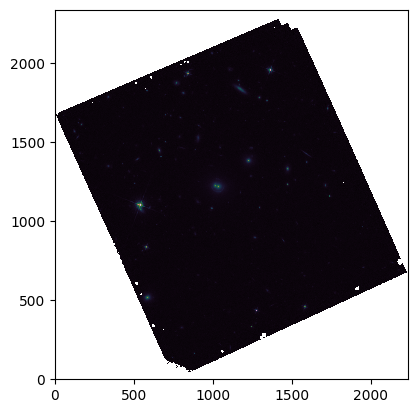

In [2]:
data, header = fits.getdata(
    "/content/drive/MyDrive/BDLensing/DESIJ0136-0008_F140W_drz_sci.fits", header=True
)

plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

<ipython-input-3-1b7fe038732e>:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data - bkg.background), origin='lower',


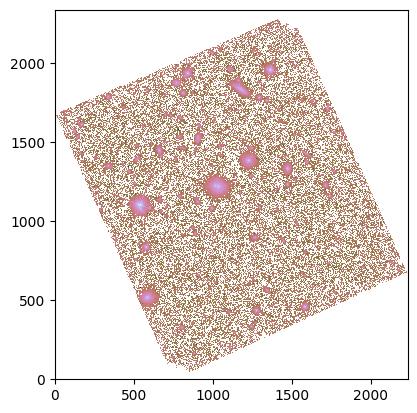

In [3]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [4]:
np.median(bkg.background), np.median(bkg.background_rms)

bkg_subtracted_data = data - bkg.background

threshold = 5 * bkg.background_rms

segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)


finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)

<photutils.segmentation.core.SegmentationImage>
shape: (2340, 2234)
nlabels: 431
labels: [  1   2   3   4   5 ... 427 428 429 430 431]
<photutils.segmentation.catalog.SourceCatalog>
Length: 431
labels: [  1   2   3   4   5 ... 427 428 429 430 431]


<ipython-input-7-1f408341beff>:4: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(data- bkg.background), origin='lower',


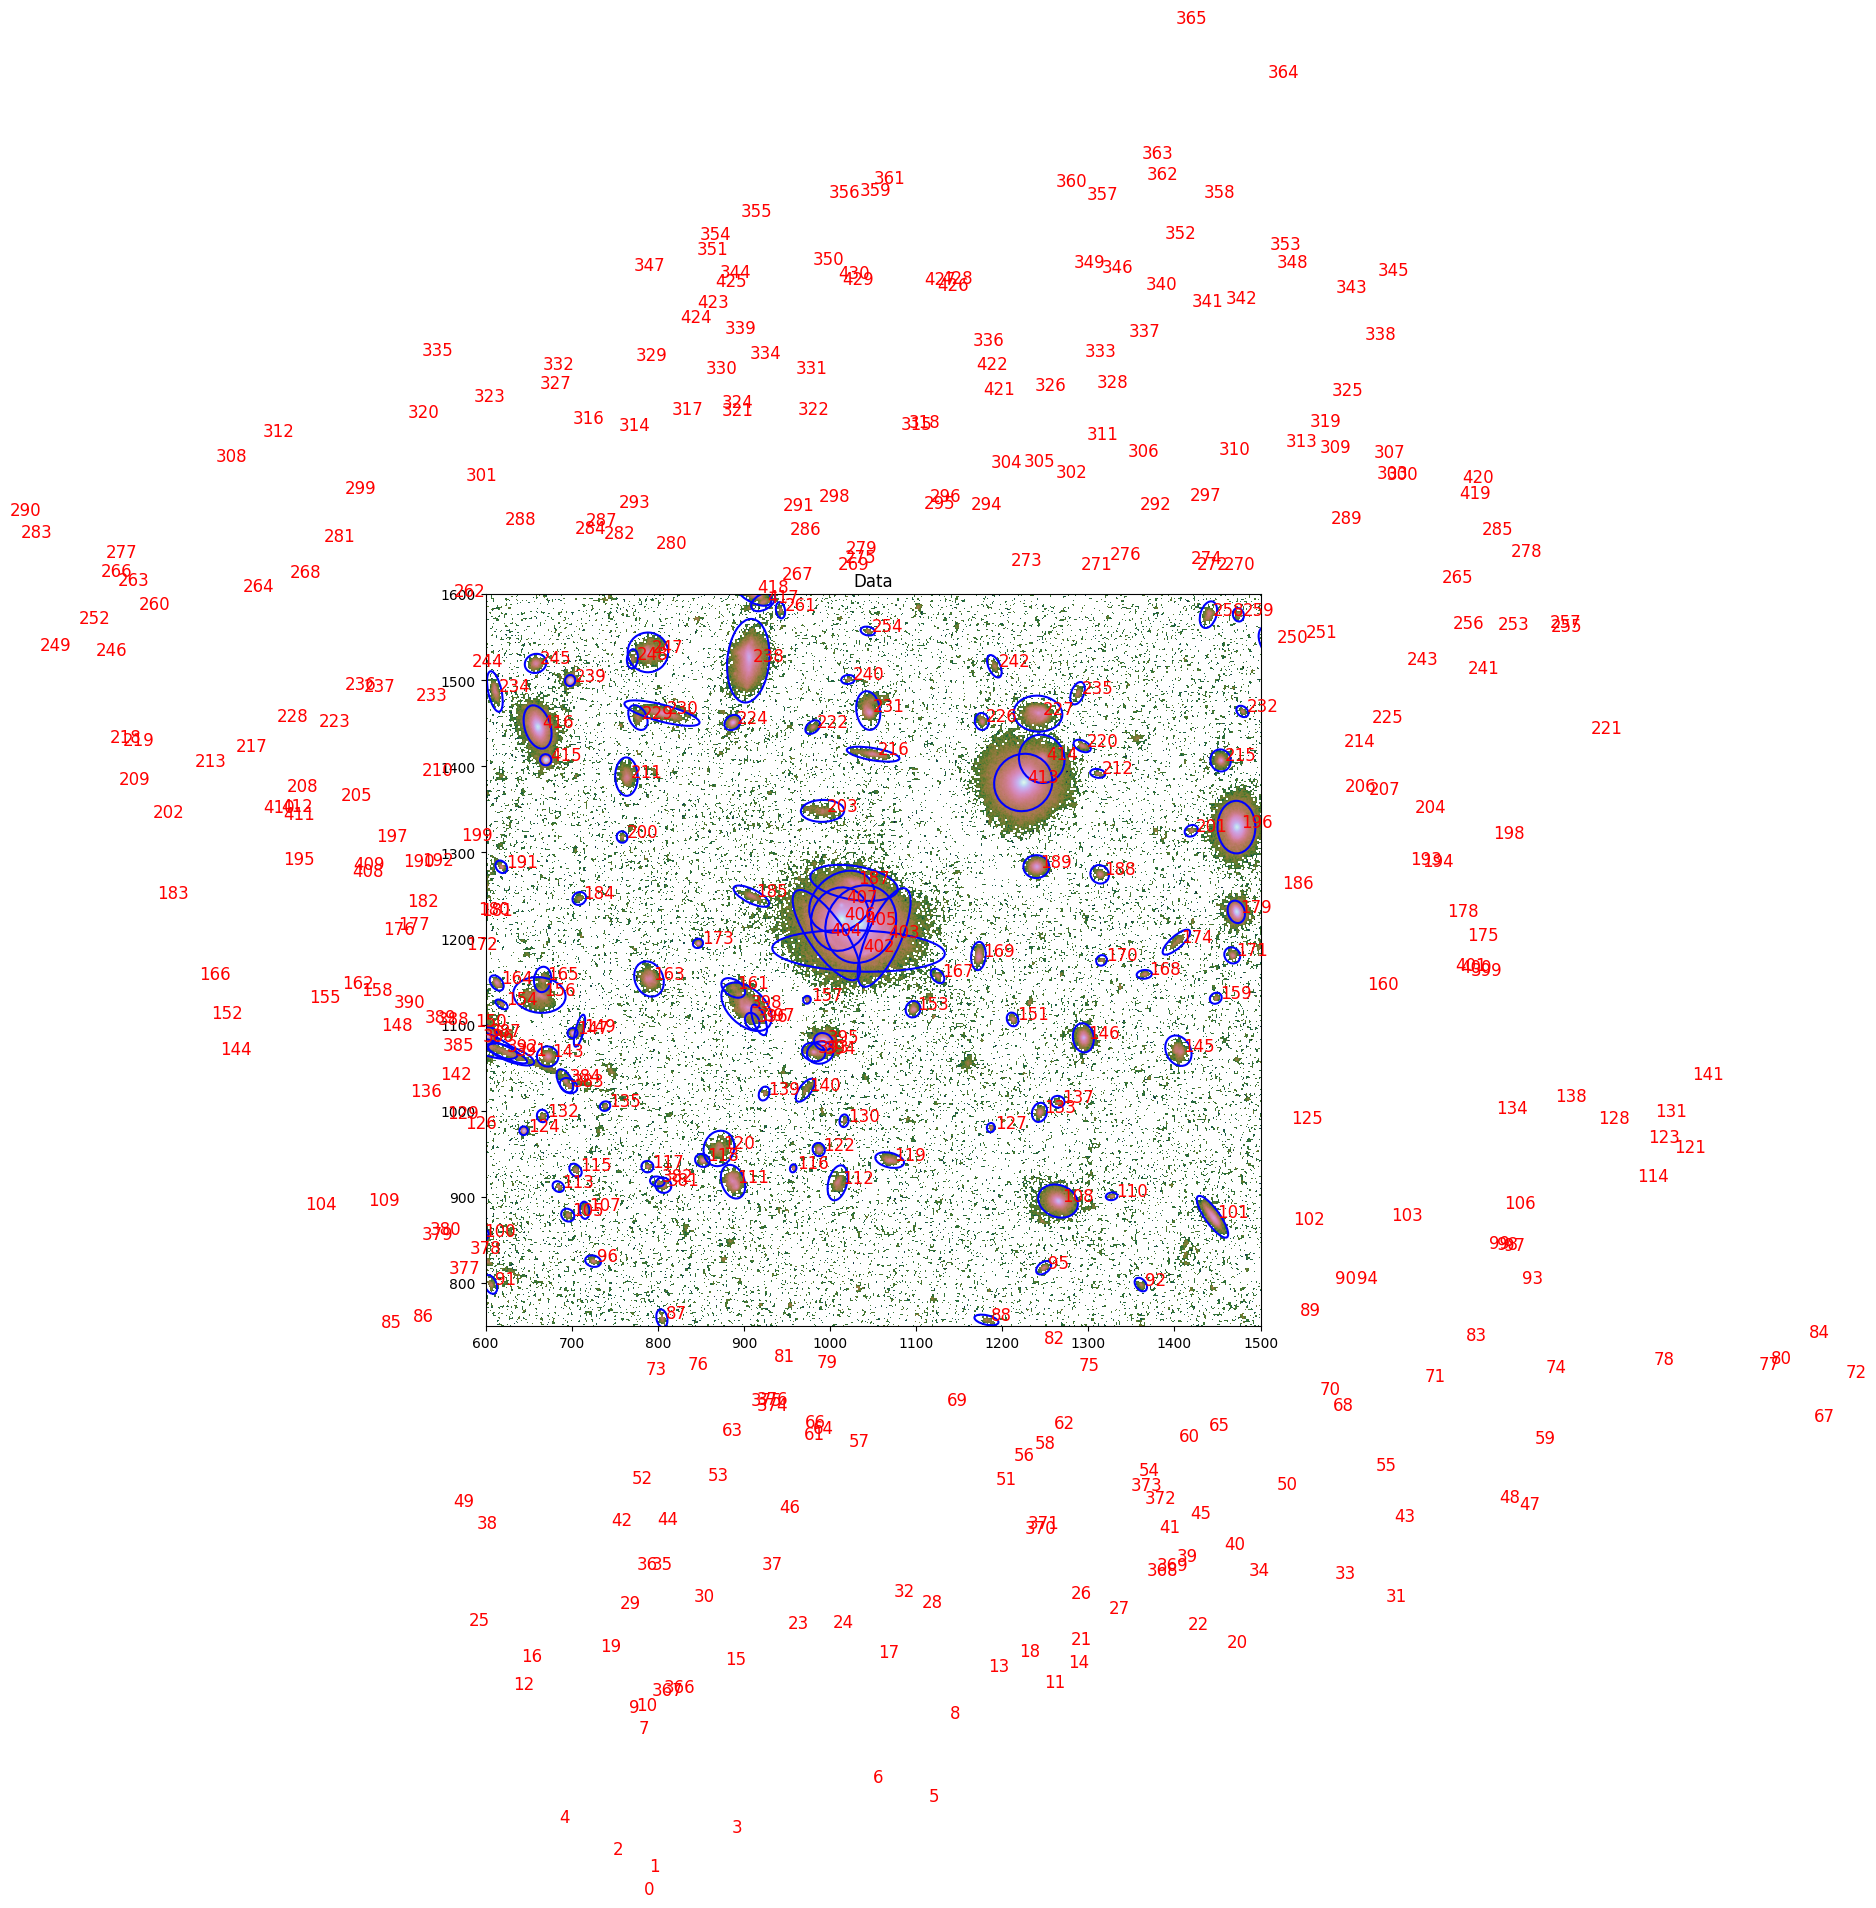

In [7]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in range(len(cat)):
    ax1.text(
        cat.xcentroid[i] + 5,
        cat.ycentroid[i],
        f"{i}",
        c="r",
        fontsize=12
        # transform=ax1.transAxes
    )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(900 - 300, 1200 + 300)
ax1.set_ylim(1050 - 300, 1300 + 300)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Close Galaxies, Distance, Flux

In [8]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

In [12]:
# close galaxies

id_central = 406  # object id of your central deflector/lens
highest_id = 417

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies = []
dist_galaxies = []
flux_galaxies = []
close_galaxies_1_percent_flux = []
dist_galaxies_1_percent_flux = []
flux_galaxies_1_percent_flux = []

for i in range(len(tbl)):
    if i == highest_id:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]

    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.05:
        close_galaxies.append(i)
        flux_galaxies.append(f)
        dist_galaxies.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.05) & (f > f0 * 0.01):
        close_galaxies_1_percent_flux.append(i)
        flux_galaxies_1_percent_flux.append(f)
        dist_galaxies_1_percent_flux.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))

print("Close galaxies:", (close_galaxies))
print("Close galaxies_1_percent_flux:", (close_galaxies_1_percent_flux))
print("Number of Close galaxies:", len(close_galaxies))
print("Number of Close galaxies_1_percent_flux:", len(close_galaxies_1_percent_flux))

Close galaxies: [111, 112, 116, 117, 118, 119, 120, 122, 127, 130, 133, 135, 137, 139, 140, 143, 146, 147, 149, 151, 153, 156, 157, 161, 163, 165, 167, 168, 169, 170, 173, 174, 184, 185, 187, 188, 189, 191, 200, 203, 211, 212, 216, 220, 222, 224, 226, 227, 229, 230, 231, 235, 238, 240, 242, 247, 248, 254, 261, 381, 382, 383, 384, 393, 394, 395, 396, 397, 398, 402, 403, 404, 405, 406, 407, 413, 414, 415, 418]
Close galaxies_1_percent_flux: [111, 120, 143, 146, 156, 163, 169, 187, 189, 211, 216, 224, 227, 230, 231, 238, 247, 393, 395, 398, 402, 403, 404, 405, 406, 407, 413, 414, 415, 418]
Number of Close galaxies: 79
Number of Close galaxies_1_percent_flux: 30


## Pixel to Arcsec

In [13]:
def distance_arcsec(x):
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

### Data frame for close galaxies with and without applying 1% flux filter

In [14]:
n_sys = 7  # number of galaxies detected inside your lensing system

df = pd.DataFrame({"Distance(pixels)": dist_galaxies})
df_1_percent_flux = pd.DataFrame({"Distance(pixels)": dist_galaxies_1_percent_flux})

df.set_index(pd.Index(close_galaxies), inplace=True)
df_1_percent_flux.set_index(pd.Index(close_galaxies_1_percent_flux), inplace=True)

df["Distance(arcsec)"] = distance_arcsec(df["Distance(pixels)"])
df["Flux"] = flux_galaxies
df_1_percent_flux["Distance(arcsec)"] = distance_arcsec(
    df_1_percent_flux["Distance(pixels)"]
)
df_1_percent_flux["Flux"] = flux_galaxies_1_percent_flux

# Sort the DataFrame based on 'Distance'
df_sorted = df.sort_values(by="Distance(pixels)")
df_1_percent_flux_sorted = df_1_percent_flux.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_sys_removed = df_sorted.iloc[n_sys:]
df_1_percent_flux_sys_removed = df_1_percent_flux_sorted.iloc[n_sys:]

# first 20 galaxies
df_20 = df_sys_removed.iloc[:20]
df_1_percent_flux_20 = df_1_percent_flux_sys_removed.iloc[:20]

print(df_20)
print(df_1_percent_flux_20)

     Distance(pixels)  Distance(arcsec)        Flux
157        101.341121          8.107290    6.093080
185        106.521558          8.521725   22.438062
203        127.317088         10.185367   29.003131
167        130.953463         10.476277    7.558991
153        134.567566         10.765405   20.237994
395        143.620809         11.489665  399.736628
161        147.642019         11.811362   16.737093
398        148.982556         11.918605  174.802819
397        150.153887         12.012311   11.511581
396        156.499151         12.519932    9.874471
394        156.746505         12.539720   27.652141
393        157.445194         12.595616   36.170664
169        166.182659         13.294613   37.959150
173        167.552794         13.404224   13.700397
216        195.280581         15.622447   37.775120
140        202.785518         16.222841    9.580194
139        220.953646         17.676292    4.346666
222        225.216898         18.017352    8.259787
151        2

### $R_{10}$, $R_{20}$ and $\Sigma_{10}$, $\Sigma_{20}$ Calculation Without filtering 1% flux

In [15]:
R_10 = df_20.iloc[9, df.columns.get_loc("Distance(arcsec)")]
R_20 = df_20.iloc[19, df.columns.get_loc("Distance(arcsec)")]
Sigma_10 = 10 / (np.pi * R_10**2)
Sigma_20 = 20 / (np.pi * R_20**2)

%store R_10
%store R_20
%store Sigma_10
%store Sigma_20

print("R 10:", R_10)
print("R 20:", R_20)
print("Sigma 10:", Sigma_10)
print("Sigma 20:", Sigma_20)

Stored 'R_10' (float64)
Stored 'R_20' (float64)
Stored 'Sigma_10' (float64)
Stored 'Sigma_20' (float64)
R 10: 12.519932068400148
R 20: 18.612068468018684
Sigma 10: 0.020307019338588774
Sigma 20: 0.018377686552116645


### $R_{10}$, $R_{20}$ and $\Sigma_{10}$, $\Sigma_{20}$ Calculation With filtering 1% flux

In [16]:
R_10_1_percent_flux = df_1_percent_flux_20.iloc[
    9, df_1_percent_flux.columns.get_loc("Distance(arcsec)")
]
R_20_1_percent_flux = df_1_percent_flux_20.iloc[
    19, df_1_percent_flux.columns.get_loc("Distance(arcsec)")
]
Sigma_10_1_percent_flux = 10 / (np.pi * R_10_1_percent_flux**2)
Sigma_20_1_percent_flux = 20 / (np.pi * R_20_1_percent_flux**2)

%store R_10_1_percent_flux
%store R_20_1_percent_flux
%store Sigma_10_1_percent_flux
%store Sigma_20_1_percent_flux

print("R 10_1_percent_flux:", R_10_1_percent_flux)
print("R 20_1_percent_flux:", R_20_1_percent_flux)
print("Sigma 10_1_percent_flux:", Sigma_10_1_percent_flux)
print("Sigma 20_1_percent_flux:", Sigma_20_1_percent_flux)

Stored 'R_10_1_percent_flux' (float64)
Stored 'R_20_1_percent_flux' (float64)
Stored 'Sigma_10_1_percent_flux' (float64)
Stored 'Sigma_20_1_percent_flux' (float64)
R 10_1_percent_flux: 21.222706976068004
R 20_1_percent_flux: 30.030414718893148
Sigma 10_1_percent_flux: 0.00706721936245185
Sigma 20_1_percent_flux: 0.007059232133156736


### Closest 20 galaxies Without filtering 1% flux Visualized

In [17]:
# 10

df_10 = df_sys_removed.iloc[:10]
galaxies_10 = df_10.index.tolist()

print(galaxies_10)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_10]

aperture_10 = CircularAperture(positions, r=20.0)

# 20
galaxies_20 = df_20.index.tolist()

print(galaxies_20)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_20]

aperture_20 = CircularAperture(positions, r=20.0)

[157, 185, 203, 167, 153, 395, 161, 398, 397, 396]
[157, 185, 203, 167, 153, 395, 161, 398, 397, 396, 394, 393, 169, 173, 216, 140, 139, 222, 151, 163]


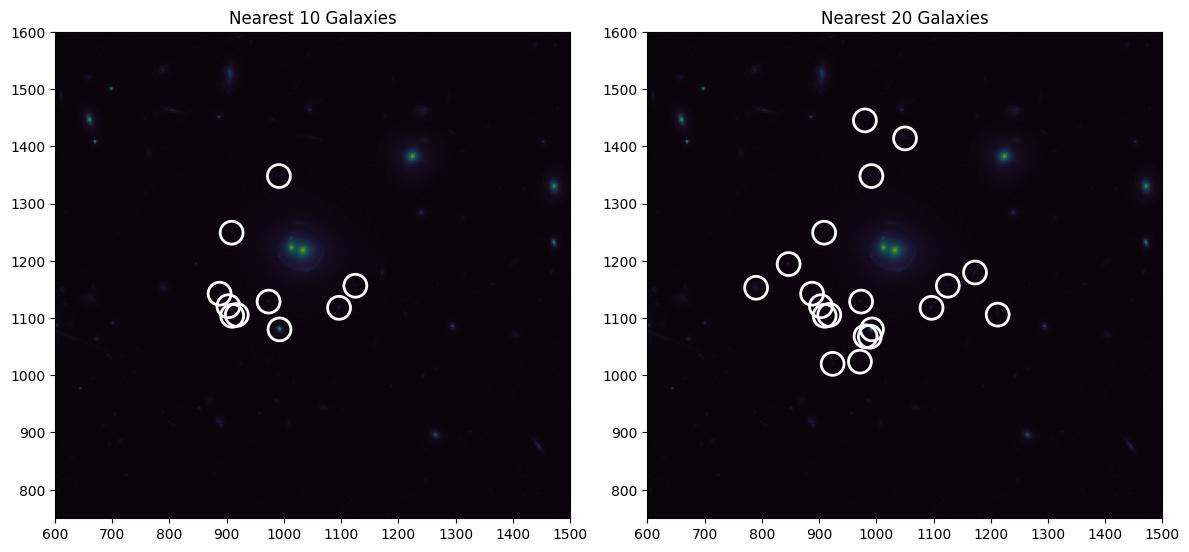

In [18]:
# Create two separate plots

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the nearest 10 galaxies from df_10 in the first subplot
axs[0].imshow(np.log10(data), interpolation="nearest", origin="lower", cmap="cubehelix")
aperture_10.plot(color="white", lw=2, ax=axs[0])

axs[0].set_xlim(900 - 300, 1200 + 300)
axs[0].set_ylim(1050 - 300, 1300 + 300)
axs[0].set_title("Nearest 10 Galaxies")

# Plot the nearest 20 galaxies from df_20 in the second subplot
axs[1].imshow(np.log10(data), interpolation="nearest", origin="lower", cmap="cubehelix")
aperture_20.plot(color="white", lw=2, ax=axs[1])
axs[1].set_xlim(900 - 300, 1200 + 300)
axs[1].set_ylim(1050 - 300, 1300 + 300)
axs[1].set_title("Nearest 20 Galaxies")


plt.tight_layout()
plt.show()

### Closest 20 galaxies With filtering 1% flux Visualized

In [19]:
# 10

df_1_percent_flux_10 = df_1_percent_flux_sys_removed.iloc[:10]

galaxies_1_percent_flux_10 = df_1_percent_flux_10.index.tolist()

print(galaxies_1_percent_flux_10)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_1_percent_flux_10]

aperture_10_flux_added = CircularAperture(positions, r=20.0)

# 20

galaxies_1_percent_flux_20 = df_1_percent_flux_20.index.tolist()

print(galaxies_1_percent_flux_20)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_1_percent_flux_20]

aperture_20_flux_added = CircularAperture(positions, r=20.0)

[395, 398, 393, 169, 216, 163, 189, 231, 224, 413]
[395, 398, 393, 169, 216, 163, 189, 231, 224, 413, 211, 414, 120, 146, 230, 238, 111, 227, 156, 143]


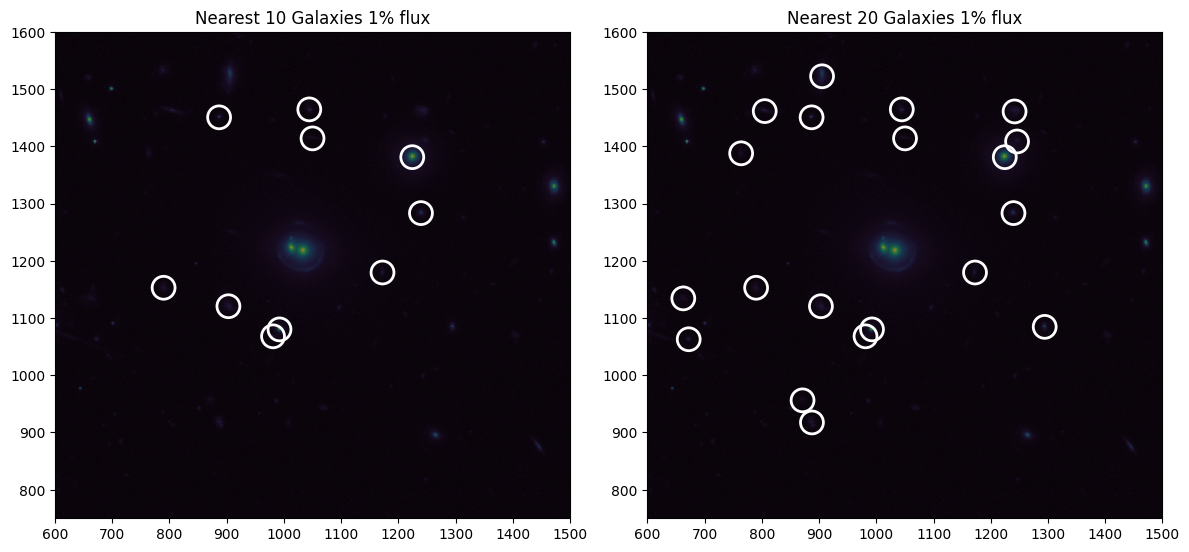

In [24]:
# Create two separate plots

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the nearest 10 galaxies from df_10 in the first subplot
axs[0].imshow(np.log10(data), interpolation="nearest", origin="lower", cmap="cubehelix")
aperture_10_flux_added.plot(color="white", lw=2, ax=axs[0])

axs[0].set_xlim(900 - 300, 1200 + 300)
axs[0].set_ylim(1050 - 300, 1300 + 300)
axs[0].set_title("Nearest 10 Galaxies 1% flux")

# Plot the nearest 20 galaxies from df_20 in the second subplot
axs[1].imshow(np.log10(data), interpolation="nearest", origin="lower", cmap="cubehelix")
aperture_20_flux_added.plot(color="white", lw=2, ax=axs[1])
axs[1].set_xlim(900 - 300, 1200 + 300)
axs[1].set_ylim(1050 - 300, 1300 + 300)
axs[1].set_title("Nearest 20 Galaxies 1% flux")


plt.tight_layout()
plt.show()